In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'    # Color is used in barcharts
fontsize=16     # Font size of a  figure title

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)


test_data = '2. Prepared Data/public_cars.csv'
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(test_data)
df_pred = pd.read_csv(prediction_data)

print("The train dataset rows: {} , columns: {} ".format(df.shape[0],df.shape[1]))
print(df.shape)
print("The test dataset rows: {} , columns: {} ".format(df_pred.shape[0],df_pred.shape[1]))
print(df_pred.shape)

The train dataset rows: 14032 , columns: 26 
(14032, 26)
The test dataset rows: 7707 , columns: 25 
(7707, 25)


In [2]:
print('Dataset: {}'.format(df.shape))
# Find missing values 
print(f'Missing values: {df.isnull().sum()}')

# Missing price
isnull_filter = df['price_usd'].isnull()
df[isnull_filter]

# Electric cars
isnull_filter = df['engine_capacity'].isnull()
df[isnull_filter]

# Filter rows with missing values
isnull_filter = (df['price_usd'].isnull() | df['engine_capacity'].isnull()) 
# Drop the row with missing price and electric cars
missing_price = len(df[isnull_filter].index)
print('\nDropped rows: {}'.format(missing_price))

# Save the rows with missing data to csv file
fl = "4. Analysis/used_car_prices_missing_data.csv"
missing_data= df[isnull_filter]
missing_data.to_csv(fl, index=False)

df.drop(df[isnull_filter].index, inplace=True)
df = df.reset_index(drop=True)
print('Dataset: {}'.format(df.shape))

# Find missing values 
print('\nMissing values: {}'.format(df.isnull().sum().sum()))

Dataset: (14032, 26)
Missing values: manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      5
body_type            0
has_warranty         0
state                0
drivetrain           1
feature_0            1
feature_1            1
feature_2            1
feature_3            1
feature_4            1
feature_5            1
feature_6            1
feature_7            1
feature_8            1
feature_9            1
duration_listed      1
price_usd            1
dtype: int64

Dropped rows: 6
Dataset: (14026, 26)

Missing values: 0


In [3]:
####################################        
# Round car price to hundreds
df['price_round']=df['price_usd'].apply(lambda x: round(x, -2))

    
 ########################       

In [4]:
###################################### OUTLIERS  ################################################

# Numerical features
mask1=(df['odometer_value'] > 250000) & (df['price_usd']>30000)
mask2=(df['year_produced'] < 1955) 
mask3=(df['year_produced'] < 1970) & (df['price_usd']>10000)
mask4=(df['engine_capacity'] < 0.8)
#mask5=(df['odometer_value/year']>95000)
mask6=(df['duration_listed']>2100)
mask7=(df['price_usd']<100) | (df['price_usd']>48000)

# Combine all filters
outliers = df[mask1|mask2|mask3|mask4|mask6|mask7] # mask5|
#outliers

# Save the rows with extreme outliers to csv file
fl = "4. Analysis/used_car_prices_EDA_extreme_outliers.csv"
outliers.to_csv(fl, index=False)
       
print("Dataset: {}".format(df.shape))
df.drop(outliers.index, inplace=True )
df.reset_index(drop=True)
print('Drop {} outliers'.format(len(outliers)))
print("Dataset: {}".format(df.shape)) 

Dataset: (14026, 27)
Drop 20 outliers
Dataset: (14006, 27)


### Feature engineering

In [5]:
# Create a class to transform columns 
class FeatureEngineering(BaseEstimator, TransformerMixin):
       
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X, y=None):
        df = X

    
  ########################################### Create features to reduce a number of categories  
    
    # Combine manufacturer and model names 
        df['name'] = df['manufacturer_name'].apply(lambda x: x.strip()) + ' ' + df['model_name'].apply(lambda x: x.strip())

        # Create a feature that represents mileage per year
        df['odometer_value']=df['odometer_value'].apply(lambda x: round(x, -2))
        df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']),-2)
        # Create a feature how old is a car
        df['year'] = 2020 - df['year_produced']

        
        # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 10
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['manufacturer_name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['manufacturer_name'] < car_total].index
        # create a new category'other' for rare car model names
        df['manufacturer_name'] = df['manufacturer_name'].apply(lambda x: 'other' if x in car_models_list else x)
        
         # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 10
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['model_name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['model_name'] < car_total].index
        # create a new category'other' for rare car model names
        df['model_name'] = df['model_name'].apply(lambda x: 'other' if x in car_models_list else x)
        
         # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 10
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['name'] < car_total].index
        # create a new category'other' for rare car model names
        df['name'] = df['name'].apply(lambda x: 'other' if x in car_models_list else x)
        
            
     
        
        # Add 'hybrid-diesel' to 'diesel' category
        df['color']=df['color'].replace({'violet':'other','yellow':'other','orange':'other', 'brown':'other'})

        # Add 'hybrid-diesel' to 'diesel' category
        df['body_type']=df['body_type'].replace({'pickup':'other','cabriolet':'other','limousine':'other'})

        # Add 'hybrid-diesel' to 'diesel' category
        df['engine_fuel']=df['engine_fuel'].replace({'hybrid-diesel':'diesel'})

        # Create a list of unnamed features
        features_list = ['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
        # Count a total number of unnamed features for a car
        df['other_features']=df[features_list].sum(axis=1).astype(int)
        
        global feats
        feats = ['name', 'odometer_value/year', 'year', 'other_features'] 
        
        return X

# Create a pipeline for feature engineering
feature_engineering = Pipeline(steps=
                               [('features', FeatureEngineering())
                               ])

# Create new features using the pipeline
df=feature_engineering.fit_transform(df)

In [6]:
# Define predictor and target variables
features =[ 'manufacturer_name', 'model_name',
           'has_warranty', 'state', 'drivetrain', 'transmission', 
           'odometer_value', 'odometer_value/year', 'year', 'engine_capacity','duration_listed', 'other_features', 
           
           #'year_produced', 
           #'engine_type',
           'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 
           'feature_6', 'feature_7', 'feature_8', 'feature_9'           
           ]

target = 'price_round'

data = df[features+ [target]].copy()
print('Dataset: {}'.format(data.shape))

Dataset: (14006, 22)


In [7]:
data.head()

,manufacturer_name,model_name,has_warranty,state,drivetrain,transmission,odometer_value,odometer_value/year,year,engine_capacity,duration_listed,other_features,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,price_round
0,Ford,Fusion,False,owned,front,mechanical,245000,17500.0,14,1.6,7.0,1,False,False,False,False,False,False,False,False,False,4200.0
1,Dodge,Caravan,False,owned,front,automatic,265500,14800.0,18,3.3,133.0,1,True,False,False,False,False,False,False,False,False,4000.0
2,Ford,Galaxy,False,owned,front,mechanical,168000,15300.0,11,1.8,0.0,5,False,False,True,False,False,True,True,True,True,10900.0
3,Mazda,6,False,owned,front,mechanical,225500,18800.0,12,1.8,20.0,5,True,True,False,False,True,False,False,True,True,7000.0
4,Audi,80,False,owned,front,mechanical,370000,12800.0,29,1.8,160.0,1,False,False,False,False,False,False,False,False,True,1600.0


#### Transformation of the target variable

In [8]:
# Copy the initial dataset before transformation
df_origin = data.copy()

# Create features and target from the data set
X = data.drop(target ,axis=1)
y = data[target]

# Reshape target variable
y = np.array(y).reshape(-1,1)

# Split the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Transform the target variable
power_tr = PowerTransformer(method='yeo-johnson')
power_tr.fit(y_train)

y_train = power_tr.transform(y_train)
y_test = power_tr.transform(y_test)

y_train = y_train.ravel()
y_test = y_test.ravel()

#### Pipeline

In [9]:
# Numeric data types
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Print numeric features
numeric_features = X.select_dtypes(numerics).columns.tolist()
print('Numeric features: {}'.format(numeric_features))


# Applies Power Transformer using Yeo-Johnson transformation to numeric columns 
numeric_power = ['odometer_value',  'odometer_value/year', 'duration_listed']

numeric_power_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('power', PowerTransformer(method='yeo-johnson')),
                                     ('scaler', StandardScaler())
                                    ])

# Applies Quantile Transformer to numeric columns 
numeric_quantile = ['engine_capacity', 'year', 'other_features']

numeric_quantile_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('quantile', QuantileTransformer(output_distribution='normal')),  
                                     ('scaler', StandardScaler())
                                    ])


# Print categorical features
categorical_features = X.select_dtypes([np.object,np.bool]).columns.tolist()
print('Categorical features: {}'.format(categorical_features))

# Transform categorical columns using OneHotEncoder
categorical_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                     ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])

# Create ColumnTransformer to perform different transformations for different columns of the data
preprocessor = ColumnTransformer(transformers=
                                     [('num_power', numeric_power_transformer, numeric_power),
                                      ('num_qt', numeric_quantile_transformer, numeric_quantile),
                                      ('cat', categorical_transformer, categorical_features)
                                     ])


Numeric features: ['odometer_value', 'odometer_value/year', 'year', 'engine_capacity', 'duration_listed', 'other_features']
Categorical features: ['manufacturer_name', 'model_name', 'has_warranty', 'state', 'drivetrain', 'transmission', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']


### Model selection

LinearRegression()
Score: 0.8901419255019543
MSE: -0.13080425757317374


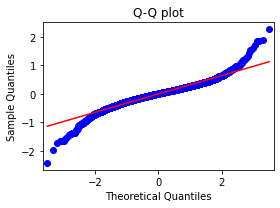

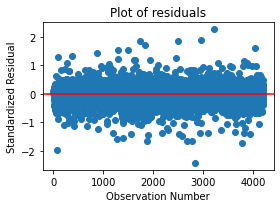

In [10]:
# Create an instance of a model
model = LinearRegression()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                 ('model', model)
                ])  
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_1 = score
mse_1 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

The qqplot for the regression model shows that the residuals generally follow a straight line, but deviate at the lower and higher quantiles. This indicates that our residuals did not follow perfect normal distribution. There might be other explanatory variables that we might consider including in our model, that could improve estimation.

LassoCV()
Score: 0.8666738396037663
MSE: -0.14243478821183939


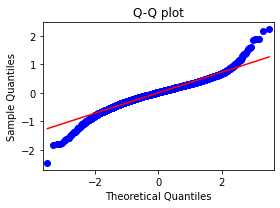

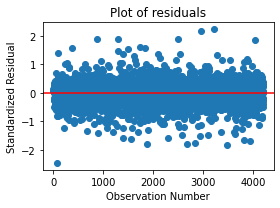

In [11]:
######################################### LassoCV model ######################################
# Create an instance of a model
model = LassoCV()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                 ('model', model)
                ])  
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_2 = score
mse_2 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
Score: 0.8908147471723714
MSE: -0.12319512123119354


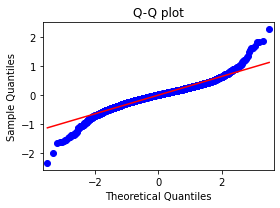

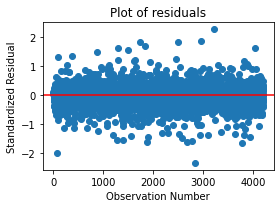

In [12]:
######################################### RidgeCV model ######################################
# Create an instance of a model
model = RidgeCV()  
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                 ('model', model)
                ])  
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_3 = score
mse_3 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

GradientBoostingRegressor()
Score: 0.8872145443577018
MSE: -0.11935016375722671


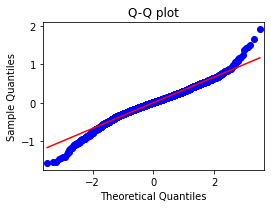

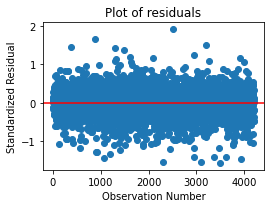

In [13]:
######################################### Gradient Boosting Regressor model ######################################
# Create an instance of a model
model = GradientBoostingRegressor()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                 ('model', model)
                ])  
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_4 = score
mse_4 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

SVR()
Score: 0.9167723802894219
MSE: -0.10316994957422279


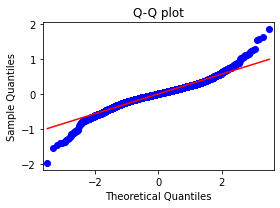

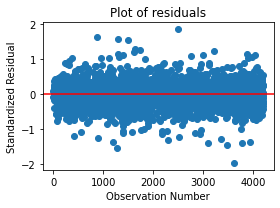

In [14]:
######################################### SVR model ######################################
# Create an instance of a model
model = SVR()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessor', preprocessor),
                 ('model', model)
                ])  
pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_5 = score
mse_5 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

In [15]:
# Compare results in one table
model_names = ['Linear Regression','LassoCV','RidgeCV','Gradient Boosting Regressor', 'SVR']
score = [score_1, score_2, score_3, score_4, score_5]
mse = [mse_1, mse_2, mse_3, mse_4, mse_5]

table = {'Score': score, 'MSE': mse}

table_df = pd.DataFrame(data=table, index=model_names)
table_df

,Score,MSE
Linear Regression,0.890142,-0.130804
LassoCV,0.866674,-0.142435
RidgeCV,0.890815,-0.123195
Gradient Boosting Regressor,0.887215,-0.119350
SVR,0.916772,-0.103170


### Model tuning

In [16]:
######################################### SVR model ######################################
# Create an instance of a model
model = SVR()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.ravel()


################################### GridS earch ###########################################
param_grid = {'model__C': [0.1, 0.5, 1, 2, 5]}
search = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train) 

#print('The best estimator: {}'.format(search.best_estimator_))
print('The best parameters: {}'.format(search.best_params_))
print('The best score: {}'.format(search.best_score_))

SVR()
The best parameters: {'model__C': 2}
The best score: 0.9099455212131478


### Final model

SVR(C=2)
Score: 0.9183777106972613
MSE: -0.0981803995420939


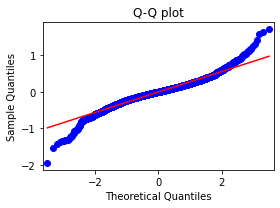

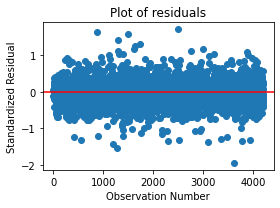

In [17]:
######################################### SVR model ######################################
# Create an instance of a model
model = search.best_estimator_['model']
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', model)])  

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

In [18]:
y_predict_test_price = power_tr.inverse_transform(y_predict_test.reshape(-1,1))
y_predict_test_price_round = np.round(y_predict_test_price,-2)
results = pd.DataFrame( {'Actual transformed':y_test.reshape(-1), 'Predicted':y_predict_test.reshape(-1),
                         'Predicted inverse transformed':y_predict_test_price.reshape(-1), 
                         'Predicted inverse transformed rounded':y_predict_test_price_round.reshape(-1)},
                       index=X_test.index)

results = results.join(df_origin['price_round'], how ='left')
results.rename(columns={'price_round':'Actual'}, inplace=True)

print('Car Prices')
results.head(10)

Car Prices


,Actual transformed,Predicted,Predicted inverse transformed,Predicted inverse transformed rounded,Actual
468,0.288630,0.396550,6745.161851,6700.0,6100.0
450,-1.105486,-1.170100,1295.546921,1300.0,1400.0
1756,-0.425141,-0.386032,3125.786962,3100.0,3000.0
7937,-1.380065,-1.429464,939.377114,900.0,1000.0
2985,-1.167258,-0.739700,2133.812880,2100.0,1300.0
1093,0.716066,0.648467,8476.712214,8500.0,9000.0
12990,1.200234,1.023721,11736.887631,11700.0,13600.0
5069,-0.559382,-0.669300,2306.689091,2300.0,2600.0
7925,1.191292,0.957913,11099.447420,11100.0,13500.0
6817,1.191292,1.072968,12233.744424,12200.0,13500.0


In [19]:
mse = mean_squared_error(results['Actual'], results['Predicted inverse transformed'])
print('MSE: {}'.format(mse))

MSE: 3045147.2820788813


In [20]:
# Save the pipeline for feature engineering
features_path = '5. Insights/Models/used_car_prices_feature_engineering.pickle'
with open(features_path, 'wb') as f:
    pickle.dump(feature_engineering, f)

print('The file {} is saved.'.format(features_path))

# Save the pipeline for model
model_path = '5. Insights/Models/used_car_prices_model.pickle'
with open(model_path, 'wb') as f:
    pickle.dump(pipe, f)

print('The file {} is saved.'.format(model_path))

# Save the PorewTransformer object for the inverse target transformation
transformer_path = '5. Insights/Models/used_car_prices_target_transformation.pickle'
with open(transformer_path, 'wb') as f:
    pickle.dump(power_tr, f)
print('The file {} is saved.'.format(transformer_path))

The file 5. Insights/Models/used_car_prices_feature_engineering.pickle is saved.
The file 5. Insights/Models/used_car_prices_model.pickle is saved.
The file 5. Insights/Models/used_car_prices_target_transformation.pickle is saved.


## Ptrediction 

In [21]:
# Load the data
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(prediction_data)

# Load a feature engineering pipeline from a file
features_path = '5. Insights/Models/used_car_prices_feature_engineering.pickle'
with open(features_path, 'rb') as f:
    feature_engineering_loaded = pickle.load(f)
print('Regression model {} is loaded.'.format(feature_engineering_loaded))

# Load a model from a file
model_path = '5. Insights/Models/used_car_prices_model.pickle'
with open(model_path, 'rb') as f:
    regression_model_loaded = pickle.load(f)
print('Regression model {} is loaded.'.format(regression_model_loaded))

# Load the PorewTransformer object for the inverse target transformation
transformer_path = '5. Insights/Models/used_car_prices_target_transformation.pickle'
with open(transformer_path, 'rb') as f:
    transformer_loaded = pickle.load(f)
print('Transformer {} is loaded.'.format(transformer_loaded))

Regression model Pipeline(steps=[('features', FeatureEngineering())]) is loaded.
Regression model Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_power',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('power',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['odometer_value',
                                                   'odometer_value/year',
                                                   'durat

In [22]:
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,False,gasoline,1.6,coupe,False,owned,front,False,True,False,False,False,False,False,True,False,True,114
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,False,gasoline,1.4,hatchback,False,owned,front,False,False,False,False,False,False,False,False,False,True,67
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,False,gasoline,2.0,minivan,False,owned,front,True,False,False,False,False,False,False,False,False,False,50
3,Volvo,XC60,mechanical,white,230000,2009,diesel,False,diesel,2.4,universal,False,owned,front,False,True,True,True,False,True,True,True,True,True,79
4,Mazda,3,mechanical,silver,206000,2007,gasoline,False,gasoline,1.6,sedan,False,owned,front,False,True,False,True,False,True,False,False,False,False,74


In [23]:
# Create new features
df=feature_engineering_loaded.fit_transform(df)

# Make prediction using the pipeline
prediction = regression_model_loaded.predict(df[features])
prediction

array([-0.92661562, -0.74468478,  0.02216237, ..., -0.37319863,
        1.16747886, -0.62729937])

In [24]:
# Transform predicted price to get the rounded car price in dollars
y_predict_price = transformer_loaded.inverse_transform(prediction.reshape(-1,1))
# Round car price to hundred
y_predict_price_round = np.round(y_predict_price,-2)
# Create a dataframe with results
results = pd.DataFrame( {'Predicted':y_predict_price.reshape(-1),
                         'Predicted rounded':y_predict_price_round.reshape(-1)},
                          index=df.index)

# Form a dataframe with car information and predicted prices
prediction_results = df.join(results)

# Save car information and predicted prices to csv file
fl = "5. Insights/Prediction/used_car_prices_prediction_data_predicted_price.csv"
prediction_results.to_csv(fl, index=False)

# Save predicted prices to csv file
fl = "5. Insights/Prediction/used_car_prices_predicted_price.csv"
results.to_csv(fl, index=False)

In [25]:
# Car information and predicted prices
prediction_results

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,name,odometer_value/year,year,other_features,Predicted,Predicted rounded
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,False,gasoline,1.6,coupe,False,owned,front,False,True,False,False,False,False,False,True,False,True,114,Renault Megane,15700.0,23,3,1726.611915,1700.0
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,False,gasoline,1.4,hatchback,False,owned,front,False,False,False,False,False,False,False,False,False,True,67,Peugeot 206,12700.0,21,1,2121.994646,2100.0
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,False,gasoline,2.0,minivan,False,owned,front,True,False,False,False,False,False,False,False,False,False,50,Volkswagen Sharan,8600.0,20,1,4724.696466,4700.0
3,Volvo,XC60,mechanical,white,230000,2009,diesel,False,diesel,2.4,universal,False,owned,front,False,True,True,True,False,True,True,True,True,True,79,Volvo XC60,20900.0,11,8,12334.328205,12300.0
4,Mazda,3,mechanical,silver,206000,2007,gasoline,False,gasoline,1.6,sedan,False,owned,front,False,True,False,True,False,True,False,False,False,False,74,Mazda 3,15800.0,13,3,5272.852609,5300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,Chrysler,other,automatic,blue,347600,2001,gasoline,False,gasoline,2.4,sedan,False,owned,front,True,False,False,False,False,False,False,False,False,False,81,other,18300.0,19,1,3303.315483,3300.0
7703,Geely,other,automatic,black,9700,2018,gasoline,False,gasoline,2.0,suv,False,owned,front,False,True,False,True,False,True,False,True,True,True,84,other,4800.0,2,6,14292.903828,14300.0
7704,Chrysler,other,automatic,red,111100,2001,gasoline,False,gasoline,2.4,sedan,False,owned,front,True,False,False,False,False,False,False,False,False,False,1,other,5800.0,19,1,3168.011249,3200.0
7705,Ford,other,mechanical,white,109000,2016,diesel,False,diesel,1.5,suv,False,owned,front,False,False,False,True,False,False,True,True,True,True,2,other,27200.0,4,5,13236.708922,13200.0


In [26]:
# Predicted car prices
results

,Predicted,Predicted rounded
0,1726.611915,1700.0
1,2121.994646,2100.0
2,4724.696466,4700.0
3,12334.328205,12300.0
4,5272.852609,5300.0
...,...,...
7702,3303.315483,3300.0
7703,14292.903828,14300.0
7704,3168.011249,3200.0
7705,13236.708922,13200.0
